In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

from sklearn.utils import shuffle


import os

import pickle

from helpers.dense_NN import train_NN, np_to_torch
from helpers.BDT import *
from helpers.physics_functions import *

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")


cuda available: True


In [24]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [26]:
# load in the data

bands = ["SBL", "SR", "SBH"]
data_dict = {}

project_id = "double_1"
particle_type = "eta"

flow_training_id = f"lowmass_{particle_type}_nojet_{project_id}"

with open(f"/global/u1/r/rmastand/dimuonAD/models/{flow_training_id}/flow_samples", "rb") as infile: 
    data_dict = pickle.load(infile)
    
with open(f"/global/u1/r/rmastand/dimuonAD/processed_data/lowmass_{particle_type}_nojet_test_band_data", "rb") as infile: 
    test_dict = pickle.load(infile)
    
with open(f"/global/u1/r/rmastand/dimuonAD/processed_data/lowmass_{particle_type}_nojet_samesign_band_data", "rb") as infile: 
    samesign_dict = pickle.load(infile)
    
    
with open(f"/global/u1/r/rmastand/dimuonAD/models/{flow_training_id}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    print(configs)
    


feature_set = ['dimu_pt', 'dimu_eta', 'mumu_deltaR', 'mumu_deltapT', 'dimu_mass']



In [27]:
# Assemble the test set -- consists of both SB and SR

feature_set = ['dimu_pt', 'dimu_eta', 'mumu_deltaR', 'mumu_deltapT', 'dimu_mass']



num_events_test_SR = test_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_test_SB = test_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+test_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_samesign = samesign_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]

test_events_SB = np.empty((num_events_test_SB, len(feature_set)))
test_events_SR = np.empty((num_events_test_SR, len(feature_set)))
test_events_samesign = np.empty((num_events_samesign, len(feature_set)))


for i, feat in enumerate(feature_set):
    
    test_events_SR[:,i] = test_dict["SR"]["s_inj_data"][feat].reshape(-1,)
    loc_arr = np.concatenate((test_dict["SBL"]["s_inj_data"][feat], test_dict["SBH"]["s_inj_data"][feat]))
    test_events_SB[:,i] = loc_arr.reshape(-1,)

    
    loc_arr = np.concatenate((samesign_dict["SR"]["s_inj_data"][feat], samesign_dict["SBL"]["s_inj_data"][feat], samesign_dict["SBH"]["s_inj_data"][feat]))
    test_events_samesign[:,i] = loc_arr.reshape(-1,)


print(data_dict["SR"].shape)
    
print(f"Total number of test events: {test_events_SR.shape[0]+test_events_SB.shape[0]}. {test_events_SR.shape[0]} in SR, {test_events_SB.shape[0]} in SB.")


(44878, 5)
Total number of test events: 31998. 2749 in SR, 29249 in SB.


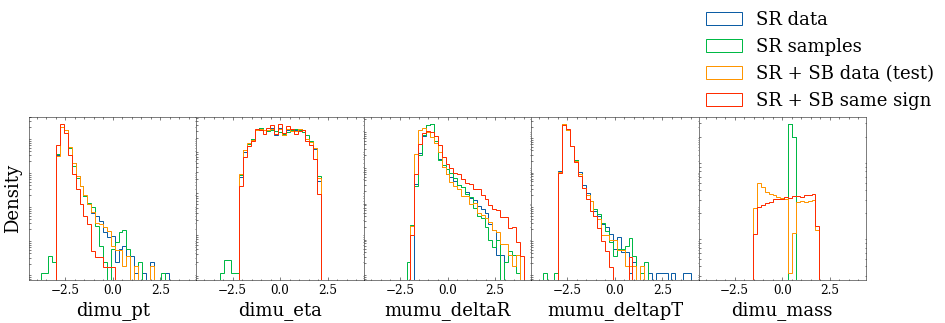

In [28]:
def hist_all_features(samples, labels, feature_set, plot_bound=3, yscale_log=False):
    scaled_feature_bins = [np.linspace(-plot_bound, plot_bound, 40) for i in range(len(feature_set))]   
    
    n_features = len(feature_set)
    fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))
        

    for i, feat in enumerate(feature_set):
        for j, samp in enumerate(samples):
            ax[i].hist(samp[:,i], bins = scaled_feature_bins[i], histtype = "step", density = True, label = labels[j])
         
        if yscale_log:
            ax[i].set_yscale("log")
        ax[i].set_xlabel(feat)
        ax[i].set_yticks([])
    plt.legend(loc = (0, 1))
    ax[0].set_ylabel("Density")
    plt.subplots_adjust(wspace=0)
    plt.show()
  

hist_all_features([data_dict["SR"], data_dict["SR_samples"], test_events_SB, test_events_samesign], ["SR data", "SR samples", "SR + SB data (test)", "SR + SB same sign"], feature_set, plot_bound = 4, yscale_log = True)



## Weight equalization

For decorrelation studies, load in flow SB samples and equalize weights

w_SBL = w_SBH, sum(w_SB) = sum(w_SB)

In [30]:
num_events_SBL_samples = data_dict["SBL_samples"].shape[0]
num_events_SBH_samples = data_dict["SBH_samples"].shape[0]
num_events_SR_samples_decorr = data_dict["SR_samples_decorr"].shape[0]


flow_samples_decorr = np.vstack([data_dict["SBL_samples"], data_dict["SR_samples_decorr"], data_dict["SBH_samples"]])
weights_decorr = np.vstack([np.full((num_events_SBL_samples,1), num_events_SR_samples_decorr/(2.0*num_events_SBL_samples)), 
                            np.full((num_events_SR_samples_decorr,1), 1),
                           np.full((num_events_SBH_samples,1), num_events_SR_samples_decorr/(2.0*num_events_SBH_samples))])

# to get neg classifier weights, assign the SR template a label of 1
labels_decorr = np.vstack([np.ones((num_events_SBL_samples,1)), 
                            np.zeros((num_events_SR_samples_decorr,1)),
                           np.ones((num_events_SBH_samples,1))])

print(flow_samples_decorr.shape, labels_decorr.shape, weights_decorr.shape)

decorrelation_array = np.hstack([flow_samples_decorr, labels_decorr, weights_decorr])
print(decorrelation_array.shape)


(522311, 5) (522311, 1) (522311, 1)
(522311, 7)


## Train the BDTs

Train to discriminate (flow samples in SR) from (test data in SR)

In [31]:
import xgboost as xgb

# BDT HYPERPARAMETERS 

# best for feature set 3
n_estimators = 600 # number of boosting stages
max_depth = 20 # max depth of individual regression estimators; related to complexity
learning_rate = 0.1
subsample = 0.5 # fraction of samples to be used for fitting the individual base learners
early_stopping_rounds = 20 # stop training BDT is validation loss doesn't improve after this many rounds



hyperparameters_dict_NN = {"n_epochs":100,
                              "batch_size": 512,
                              "lr": .001,
                             }



In [40]:
def run_BDT_bump_hunt(flow_samples_SR, data_samples_SR, data_samples_SB, num_folds, num_to_ensemble, 
                      alt_test_sets_data={}, network_type="bdt", visualize=True, decorrelation_array=None, decor_strength=0.1):
    
    """
    Classifier is trained only on SR data, to distinguish flow SR samples from SR data
    
    Classifier is evaluated on test data from SR AND SB
    
    Note that alt test sets are NOT split into folds, since we aren't training on them. We do get diff scores for each fold
    """
    
    test_data_splits = {i:0 for i in range(num_folds)}
    scores_splits = {i:0 for i in range(num_folds)}
    
    alt_scores_splits = {}
    for alt_id in alt_test_sets_data.keys():
        alt_scores_splits[alt_id] = {i:0 for i in range(num_folds)}
        
        
    # shuffle anything with SB data to mix the low and high masses before splitting 
    data_samples_SB = shuffle(data_samples_SB)
    decorrelation_array = shuffle(decorrelation_array)
    
    flow_SR_splits = np.array_split(flow_samples_SR, num_folds)
    data_SR_splits = np.array_split(data_samples_SR, num_folds)
    data_SB_splits = np.array_split(data_samples_SB, num_folds) 
    decorr_splits = np.array_split(decorrelation_array, num_folds)
    
    for i_fold in range(num_folds):
            
        print(f"Fold {i_fold}:")
        
        """
        ASSEMBLE THE TRAIN / VAL / TEST DATA
        """
        
        # Assemble the train / test data in a hacky way
        training_data = []
        training_labels = []
        validation_data = []
        validation_labels = []
        testing_data = []
        
        decorr_train_array = []
        decorr_val_array = []
        
        
        for ii in range(num_folds):
            
            # test set comprised of SR and SB data
            if ii == i_fold:
                testing_data.append(data_SR_splits[ii])
                testing_data.append(data_SB_splits[ii])
                
            # validation set: flow SR samples, data SR sampkes
            elif ((ii+1)%num_folds) == i_fold:
                validation_data.append(flow_SR_splits[ii])
                validation_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                validation_data.append(data_SR_splits[ii])
                validation_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                decorr_val_array.append(decorr_splits[ii])
                
            else:
                training_data.append(flow_SR_splits[ii])
                training_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                training_data.append(data_SR_splits[ii])
                training_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                decorr_train_array.append(decorr_splits[ii])
                
        X_train_fold = np.concatenate(training_data)
        Y_train_fold = np.concatenate(training_labels)
        X_val_fold = np.concatenate(validation_data)
        Y_val_fold = np.concatenate(validation_labels)
        X_test_fold = np.concatenate(testing_data)
        decorr_train = np.concatenate(decorr_train_array)
        decorr_val = np.concatenate(decorr_val_array)
        
        # record the local fold data
        test_data_splits[i_fold] = X_test_fold

     
        """
        SORT THE WEIGHTS OUT
        """
        
        # First do the weights for the regular BC (non-decorr)
        class_weight = {0: 1, 1: sum(Y_train_fold==0)[0]/sum(Y_train_fold==1)[0]}
        class_weights_train = class_weight[0]*(1.0-Y_train_fold)+class_weight[1]*Y_train_fold
        class_weights_val = class_weight[0]*(1.0-Y_val_fold)+class_weight[1]*Y_val_fold
        
        """
        COMBINE W/ DECORRELATED TRAINING
        """
        # we only want to train on the non-mass features
        if decor_strength > 0:
            
            X_train_fold = np.vstack([X_train_fold[:,:-1], decorr_train[:,:-3]])
            X_val_fold = np.vstack([X_val_fold[:,:-1], decorr_val[:,:-3]])

            Y_train_fold = np.vstack([Y_train_fold, decorr_train[:,-2].reshape(-1,1)])
            Y_val_fold = np.vstack([Y_val_fold, decorr_val[:,-2].reshape(-1,1)])

            w_train_fold = np.vstack([class_weights_train, decor_strength*decorr_train[:,-1].reshape(-1,1)])
            w_val_fold = np.vstack([class_weights_val, decor_strength*decorr_val[:,-1].reshape(-1,1)])
            
        else:
            X_train_fold = X_train_fold[:,:-1]
            X_val_fold = X_val_fold[:,:-1]

            w_train_fold = class_weights_train
            w_val_fold = class_weights_val

        # shuffle for good measure
        X_train_fold, Y_train_fold, w_train_fold = shuffle(X_train_fold, Y_train_fold, w_train_fold)
        X_val_fold, Y_val_fold, w_val_fold = shuffle(X_val_fold, Y_val_fold, w_val_fold)
        
        X_test_fold = X_test_fold[:,:-1]
        

        
        print(f"X train shape: {X_train_fold.shape}, Y train shape: {Y_train_fold.shape}, w train shape: {w_train_fold.shape}.")
        print(f"X val shape: {X_val_fold.shape}, Y val shape: {Y_val_fold.shape}, w val shape: {w_val_fold.shape}.")
        print(f"X test shape: {X_test_fold.shape}." )
        
        """
        INITIALIZE SCORE OBJECTS
        """
        scores_fold = np.empty((X_test_fold.shape[0], num_to_ensemble))
        alt_scores_fold = {}
        for alt_id in alt_test_sets_data.keys():
            alt_scores_fold[alt_id] = np.empty((alt_test_sets_data[alt_id].shape[0], num_to_ensemble))
            
   
        """
        TRAIN ENSEMBLE OF TREES
        """
    
        if visualize:
            plt.figure()
        
        for i_tree in range(num_to_ensemble):
            
            print("   Network number:", i_tree)
            random_seed = i_fold*num_to_ensemble + i_tree + 1
                
            if network_type == "bdt":
                
                eval_set = [(X_train_fold, Y_train_fold), (X_val_fold, Y_val_fold)]

                bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                                  subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                                  objective='binary:logistic', 
                                          random_state = random_seed, eval_metric="logloss")

                bst_i.fit(X_train_fold, Y_train_fold, sample_weight=w_train_fold, 
                          eval_set=eval_set, sample_weight_eval_set = [w_train_fold, w_val_fold],
                          verbose=False)
                results_f = bst_i.evals_result()
                losses = results_f["validation_0"]["logloss"]
                losses_val = results_f["validation_1"]["logloss"]
                best_epoch = bst_i.best_iteration
                
                
                # get scores
                scores_fold[:,i_tree] = bst_i.predict_proba(X_test_fold, iteration_range=(0,bst_i.best_iteration))[:,1]
                for alt_id in alt_test_sets_data.keys():
                    alt_scores_fold[alt_id][:,i_tree] = bst_i.predict_proba(alt_test_sets_data[alt_id][:,:-1], iteration_range=(0,bst_i.best_iteration))[:,1]
            
            elif network_type == "nn":

                results_path = "loc_nn"
                loc_scaler, losses, losses_val, best_epoch = train_NN(X_train_fold, Y_train_fold, w_train_fold, 
                                                            X_val_fold, Y_val_fold, w_val_fold, random_seed, 
                                                            [32], hyperparameters_dict_NN, device, results_path=results_path)
        
                dense_net_eval = torch.load(f"{results_path}.pt")
                dense_net_eval.eval()
                with torch.no_grad():
                    scores_fold[:,i_tree] = dense_net_eval(np_to_torch(loc_scaler.transform(X_test_fold), device)).detach().cpu().numpy().reshape(-1,)
                    for alt_id in alt_test_sets_data.keys():
                        alt_scores_fold[alt_id][:,i_tree] =  dense_net_eval(np_to_torch(loc_scaler.transform(alt_test_sets_data[alt_id][:,:-1]), device)).detach().cpu().numpy().reshape(-1,)
            
            if visualize:
                
                plt.plot(losses, label = f"{i_tree}", color = f"C{i_tree}")
                plt.plot(losses_val, color = f"C{i_tree}", linestyle = "dashed")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.axvline(best_epoch, color = f"C{i_tree}")
                plt.title(f"Fold {i_fold}")
        
        if visualize:
            plt.legend()
            plt.show()
        
            
            
        """
        AVERAGE OVER ENSEMBLE
        """
            
        scores_splits[i_fold] = np.mean(scores_fold, axis = 1)
        for alt_id in alt_test_sets_data.keys():
            alt_scores_splits[alt_id][i_fold] = np.mean(alt_scores_fold[alt_id], axis = 1)
            
        print()


    return test_data_splits, scores_splits, alt_scores_splits




  0%|          | 0/100 [00:00<?, ?it/s]

Fold 0:
X train shape: (341963, 4), Y train shape: (341963, 1), w train shape: (341963, 1).
X val shape: (113986, 4), Y val shape: (113986, 1), w val shape: (113986, 1).
X test shape: (6400, 4).
   Network number: 0


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 1


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 2


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 3


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 4


 55%|█████▌    | 55/100 [03:26<02:48,  3.75s/it]


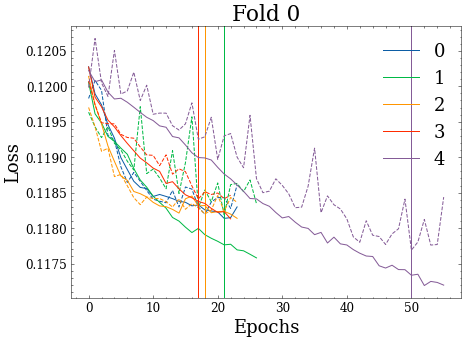

  0%|          | 0/100 [00:00<?, ?it/s]


Fold 1:
X train shape: (341961, 4), Y train shape: (341961, 1), w train shape: (341961, 1).
X val shape: (113989, 4), Y val shape: (113989, 1), w val shape: (113989, 1).
X test shape: (6400, 4).
   Network number: 0


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 1


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 2


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 3


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 4


 21%|██        | 21/100 [01:23<05:13,  3.97s/it]


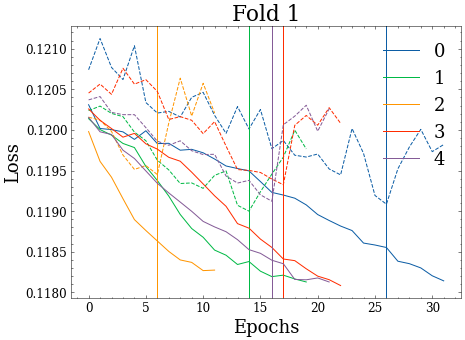

  0%|          | 0/100 [00:00<?, ?it/s]


Fold 2:
X train shape: (341962, 4), Y train shape: (341962, 1), w train shape: (341962, 1).
X val shape: (113988, 4), Y val shape: (113988, 1), w val shape: (113988, 1).
X test shape: (6400, 4).
   Network number: 0


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 1


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 2


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 3


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 4


 37%|███▋      | 37/100 [02:15<03:50,  3.66s/it]


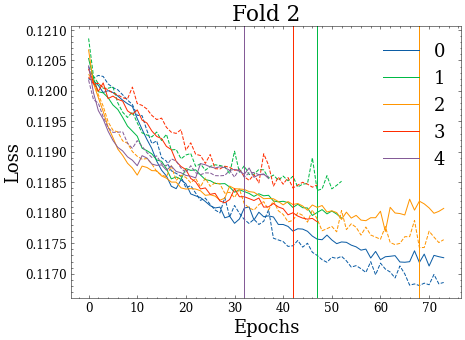

  0%|          | 0/100 [00:00<?, ?it/s]


Fold 3:
X train shape: (341963, 4), Y train shape: (341963, 1), w train shape: (341963, 1).
X val shape: (113988, 4), Y val shape: (113988, 1), w val shape: (113988, 1).
X test shape: (6400, 4).
   Network number: 0


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 1


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 2


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 3


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 4


 22%|██▏       | 22/100 [01:29<05:17,  4.07s/it]


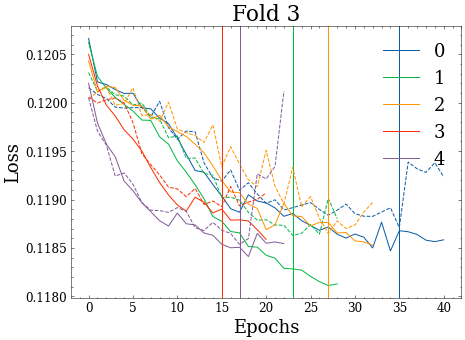

  0%|          | 0/100 [00:00<?, ?it/s]


Fold 4:
X train shape: (341965, 4), Y train shape: (341965, 1), w train shape: (341965, 1).
X val shape: (113987, 4), Y val shape: (113987, 1), w val shape: (113987, 1).
X test shape: (6398, 4).
   Network number: 0


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 1


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 2


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 3


  0%|          | 0/100 [00:00<?, ?it/s]

   Network number: 4


 22%|██▏       | 22/100 [01:23<04:54,  3.78s/it]


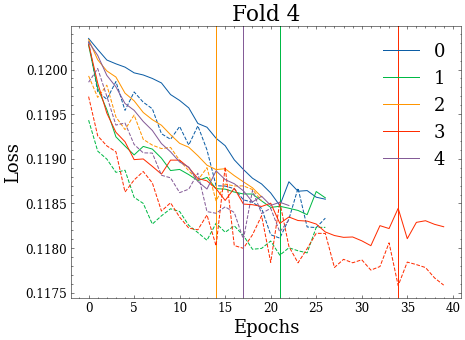

In [41]:
# Train a classifier to discriminate SR samples from SR data

n_folds = 5
n_to_ensemble = 5


test_data_splits, scores_splits, alt_scores_splits = run_BDT_bump_hunt(data_dict["SR_samples"], 
                                        test_events_SR, test_events_SB, n_folds, n_to_ensemble, 
                                            alt_test_sets_data = {"FPR_validation":data_dict["SR_samples_validation"],"samesign":test_events_samesign},
                                                                      network_type="nn", visualize=True, decorrelation_array=decorrelation_array)



## Analysis


### True bump hunt

- Define a polynomial form for the background fit
- For each cut on the classifier score:
  - Fit the background on the cut SB data
  - Estimate N_bkg
  - Calculate S/B, S/sqrt(B)



In [42]:
with open(f"processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
sorted_masses_splits = {}

fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.002, 0.001]
score_cutoffs = {i:[] for i in range(n_folds)}


for i_fold in range(n_folds):
    
    """ 
    # OLD METHOD: SORTING SCORES
    # sort the scores
    loc_sorted_indices = np.argsort(scores_splits[i_fold])
    
    # get the true masses from low to high score
    sorted_masses_splits[i_fold] = scaler.inverse_transform(np.array(test_data_splits[i_fold][:,-1][loc_sorted_indices]).reshape(-1,1))
   
    
    plt.figure()
    plt.hist(alt_scores_splits["FPR_validation"][i_fold], bins = np.linspace(0, 1, 40), histtype = "step", density = True, label = "FPR")
    plt.hist(scores_splits[i_fold], bins = np.linspace(0, 1, 40), histtype = "step", density = True, label = "test")
    plt.hist(alt_scores_splits["samesign"][i_fold], bins = np.linspace(0, 1, 40), histtype = "step", density = True, label = "ss")
    plt.legend()
    plt.show()
    """
    
    # NEW METHOD: score cutoff from vaidation fpr
    # from EBH paper
    
    for t in fpr_thresholds:
        
        loc_scores_sorted = np.sort(1.0-alt_scores_splits["FPR_validation"][i_fold])
        score_cutoff = 1-loc_scores_sorted[min(int(t*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
   
        score_cutoffs[i_fold].append(score_cutoff)  
print(score_cutoffs)

{0: [0.3348813593387604, 0.5070615172386169, 0.5249360561370849, 0.5476320028305054, 0.5787539124488831, 0.6093033194541931, 0.6204738616943359], 1: [0.3911065459251404, 0.5046184062957764, 0.5154582440853119, 0.5251297950744629, 0.5452528953552246, 0.5665629148483277, 0.592358934879303], 2: [0.2820609331130981, 0.5160548329353333, 0.5356289148330688, 0.5482652306556701, 0.5837129116058349, 0.6233067274093628, 0.6454716205596924], 3: [0.42245875597000127, 0.5025843799114227, 0.5144209325313568, 0.5245078325271606, 0.5488303303718567, 0.5999685764312744, 0.638430368900299], 4: [0.34330902099609373, 0.5044405043125153, 0.5188099145889282, 0.5357684373855591, 0.5648638010025024, 0.5865948677062989, 0.5959254980087281]}


chi2/dof: 1.117325023448041
chi2/dof: 8.669714184175804
chi2/dof: 20.016585318788774
chi2/dof: 40.230501894821884
chi2/dof: inf
chi2/dof: inf
chi2/dof: inf



/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:94: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:94: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:94: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


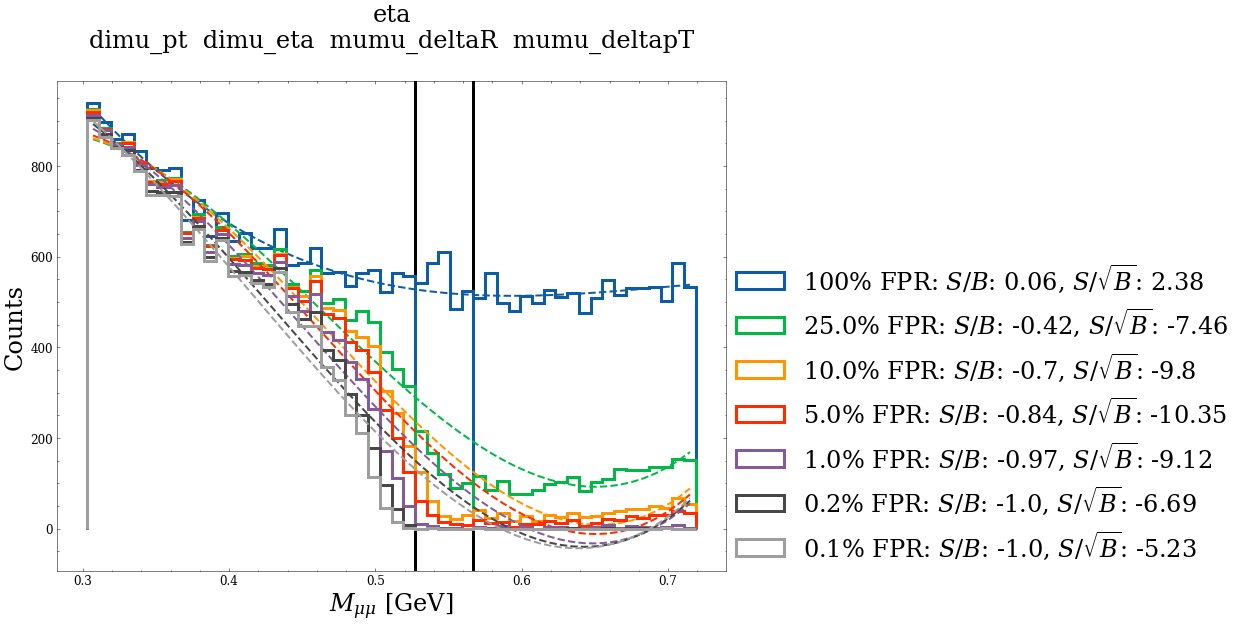

In [43]:
SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])
    
    
plot_bins_SR = np.linspace(SR_left, SR_right, 6)
x_SR_center = 0.5*(plot_bins_SR[1:] + plot_bins_SR[:-1])
width = plot_bins_SR[1] - plot_bins_SR[0]
x = np.linspace(SB_left, SB_right, 100)


remove_edge = True



fit_type = "cubic"

if fit_type == "cubic":
    p0  = [5000, -20000, 30000, -10000]
    bkg_fit_function = bkg_fit_cubic
    n_dof_fit = 4
    
elif fit_type == "quintic":
    p0  = [5000, -20000, 30000, -10000, 0, 0]
    bkg_fit_function = bkg_fit_quintic
    n_dof_fit = 6
    
elif fit_type == "ratio":
    p0  = [1000,1000,0.1]
    bkg_fit_function = bkg_fit_ratio
    n_dof_fit = 3


plt.figure(figsize = (12, 9))
#for p, percent in enumerate([100, 80, 60, 40, 20]):
for p, threshold in enumerate(fpr_thresholds):
    
        
    filtered_masses = []
    
    for i_fold in range(n_folds):
        """
        # grab the top percent of events FROM EACH FOLD
        loc_num_events_to_take = int(percent*sorted_masses_splits[i_fold].shape[0]/100)
        filtered_masses.append(np.array(sorted_masses_splits[i_fold][-loc_num_events_to_take:]).reshape(-1,1))
        """
        
        # get the true masses
        loc_true_masses = scaler.inverse_transform(np.array(test_data_splits[i_fold][:,-1]).reshape(-1,1))
        # get the events that pass the score threshold
        pass_scores = scores_splits[i_fold] >= score_cutoffs[i_fold][p]
        filtered_masses.append(loc_true_masses[pass_scores])
        

    filtered_masses = np.concatenate(filtered_masses)
    
    
    popt, pcov, chi2, dof_data, plot_bins_left, plot_bins_right = curve_fit_m_inv(filtered_masses, bkg_fit_function, SB_left, SB_right, SR_left, SR_right, width, p0, remove_edge = True)
    #print(popt)
    
    plot_bins = np.concatenate([plot_bins_left, plot_bins_SR, plot_bins_right])
    plot_centers = 0.5*(plot_bins[1:] + plot_bins[:-1])

    n_dof = dof_data - n_dof_fit
    print("chi2/dof:", chi2/n_dof)
    
    plt.plot(plot_centers, bkg_fit_function(plot_centers, *popt), lw = 2, linestyle = "dashed", color = f"C{p}")
    #plt.scatter(plot_centers, bkg_fit_function(plot_centers, *popt),color = f"C{p}")
    
    
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, bkg_fit_function, plot_bins_SR, SR_left, SR_right, popt)
    #print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, x_SR_center, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins, lw = 3, histtype = "step", color = f"C{p}",label = label_string)
    
    
    
    
print() 
plt.legend(loc = (1, 0), fontsize = 24)
#plt.yscale("log")

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type}\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)
plt.show()





Repeat for samesign background

chi2/dof: 5.514017436861182
chi2/dof: 32.649730033448556
chi2/dof: 114.48020098393786
chi2/dof: 215.5373891617127
chi2/dof: 706.3238841443014
chi2/dof: inf
chi2/dof: inf


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:94: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:94: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


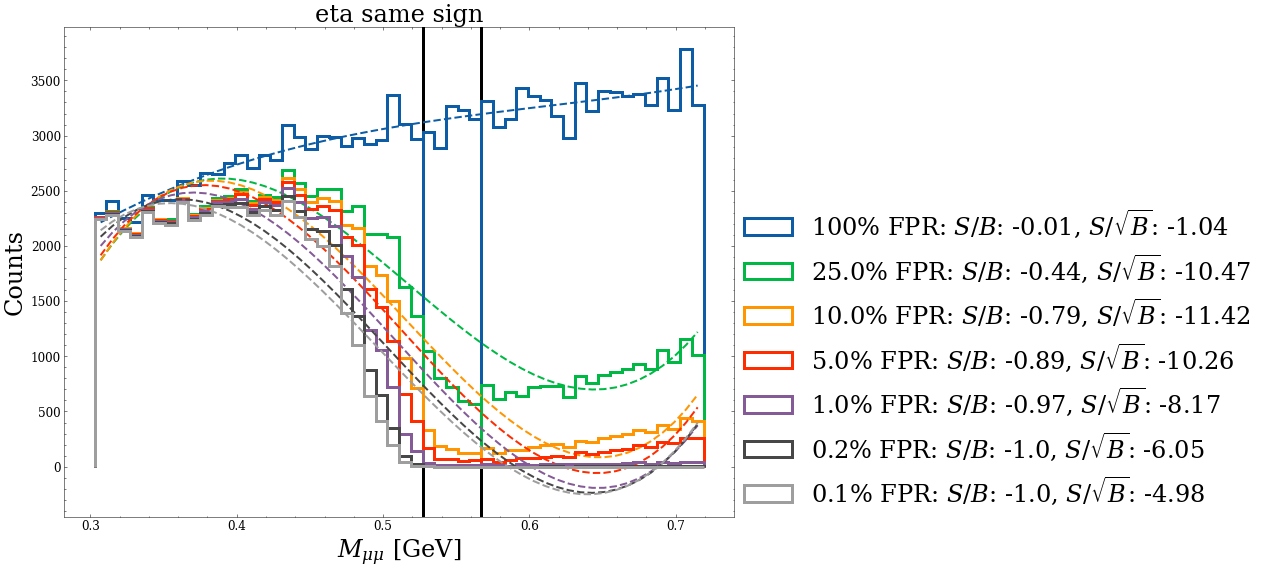

In [44]:
fit_type = "cubic"

if fit_type == "cubic":
    p0  = [5000, -20000, 30000, -10000]
    bkg_fit_function = bkg_fit_cubic
    n_dof_fit = 4
    
elif fit_type == "quintic":
    p0  = [5000, -20000, 30000, -10000, 0, 0]
    bkg_fit_function = bkg_fit_quintic
    n_dof_fit = 6
    
elif fit_type == "ratio":
    p0  = [1000,1000,0.1]
    bkg_fit_function = bkg_fit_ratio
    n_dof_fit = 3


plt.figure(figsize = (12, 9))
#for p, percent in enumerate([100, 80, 60, 40, 20]):
for p, threshold in enumerate(fpr_thresholds):
        
    filtered_masses = []
    
    for i_fold in range(n_folds):
        """
        loc_sorted_indices = np.argsort(alt_scores_splits["samesign"][i_fold])
        loc_sorted_masses = scaler.inverse_transform(np.array(test_events_samesign[:,-1][loc_sorted_indices]).reshape(-1,1))

        
        # grab the top percent of events FROM EACH FOLD
        loc_num_events_to_take = int(percent*loc_sorted_masses.shape[0]/100)
        filtered_masses.append(np.array(loc_sorted_masses[-loc_num_events_to_take:]).reshape(-1,1))
        """
        
        # get the true masses
        loc_true_masses = scaler.inverse_transform(test_events_samesign[:,-1].reshape(-1,1))
        # get the events that pass the score threshold
        pass_scores = alt_scores_splits["samesign"][i_fold] >= score_cutoffs[i_fold][p]
        filtered_masses.append(loc_true_masses[pass_scores])
        
        
    filtered_masses = np.concatenate(filtered_masses)
    
    popt, pcov, chi2, dof_data, plot_bins_left, plot_bins_right = curve_fit_m_inv(filtered_masses, bkg_fit_function, SB_left, SB_right, SR_left, SR_right, width, p0, remove_edge = True)
    #print(popt)
    
    plot_bins = np.concatenate([plot_bins_left, plot_bins_SR, plot_bins_right])
    plot_centers = 0.5*(plot_bins[1:] + plot_bins[:-1])

    n_dof = dof_data - n_dof_fit
    print("chi2/dof:", chi2/n_dof)
    
    plt.plot(plot_centers, bkg_fit_function(plot_centers, *popt), lw = 2, linestyle = "dashed", color = f"C{p}")
    #plt.scatter(plot_centers, bkg_fit_function(plot_centers, *popt),color = f"C{p}")
    
    
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, bkg_fit_function, plot_bins_SR, SR_left, SR_right, popt)
    #print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, x_SR_center, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins, lw = 3, histtype = "step", color = f"C{p}",label = label_string)
    
    
    
    
    
#plt.title(",  ".join(feature_set[:-1])+"\n", fontsize = 18) 
plt.legend(loc = (1, 0), fontsize = 24)
#plt.yscale("log")

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type} same sign", fontsize = 24)

plt.show()